In [64]:
Packages <- c("factoextra","dplyr","pracma","data.table","cubature", "gridExtra","viridis", "ggsignif", "broom", "ggpubr", "caret","cowplot","ggplot2","fields","bbmle", "dplyr", "tidyr", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/parentage/kernel_fitting/')

load("~/parentage/r_data/site_dist_info.RData")
load("~/parentage/r_data/site_width_info.RData")


#final scripts to use
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_grid_search.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum0.5.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum1.R")

"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0

In [2]:
# read in kernel results 
kernels <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/kernel_fitting_summary.csv", header=T)
kernels

Year,best_k,best_theta,k_CI95_lower,k_CI95_upper,theta_CI95_lower,theta_CI95_upper,MeanDispDist,MeanDispDist_CI95_lower,MeanDispDist_CI95_upper,NumParentageMatches,NumOffsSampled,PercentAssigned,MedianDispDist,Dist90Retained,MedianDispDist_CI95_lower,MedianDispDist_CI95_upper
2012,-2.36,1.03,-7.22,-1.90,0.48,1.10,10.165094,0.000000,1.367946e+26,3,63,4.76,7.13,23.29,3.19,1.530115e+13
2013,4.04,0.22,3.59,4.06,0.20,0.24,69.586280,7.978681,1.233879e+05,21,150,14.00,12.20,157.36,2.57,2.061640e+03
2014,0.49,0.38,-0.26,0.81,0.37,0.40,15.037515,5.646667,2.204186e+05,13,181,7.18,5.53,38.13,3.02,2.984700e+03
2015,-1.52,0.67,-2.08,-1.13,0.56,0.70,10.180222,6.149556,2.404633e+02,11,111,9.91,5.82,24.91,2.31,1.118000e+01
2016,-3.04,5.00,-3.07,-2.88,2.16,5.00,10.100794,7.600055,1.311733e+01,6,111,5.41,9.63,18.91,5.85,4.458000e+01
2017,2.94,0.26,2.66,3.64,0.23,0.26,29.062101,5.920487,1.172967e+04,13,130,10.00,6.68,69.72,3.03,5.452225e+05
2018,-2.32,1.37,-2.93,-2.15,1.36,1.61,7.191634,4.507346,5.079209e+01,4,45,8.89,5.55,15.72,2.58,1.276000e+01
2012-18,-2.51,1.49,-2.51,-2.48,1.32,1.60,8.153016,7.132250,9.403629e+00,71,791,8.98,6.44,17.58,4.94,8.130000e+00


# look for correlations between connections across years

In [ ]:
#from Allison
# Define function with the right parameters
k18 <- as.numeric(kernels %>%
                     filter(Year=="2018") %>%
                     select(best_k))
theta18 <- as.numeric(kernels %>%
                     filter(Year=="2018") %>%
                     select(best_theta))


k <- k18
theta <- theta18

#Create connectivity df
  cdf18 <- site_dist_info %>% 
    select(org_site, dest_site, dist_mid_to_mid_km, d1_km, d2_km, org_alpha_order, org_geo_order, dest_alpha_order, dest_geo_order)
  
for(i in 1:length(cdf18$org_site)) {
    
    dist_eval <- as.vector(as.matrix(cdf18 %>%
        filter(row_number()==i) %>%
        select(d1_km, d2_km)))
    
    d1_km <- min(dist_eval)
    d2_km <- max(dist_eval)
    
    cdf18$prob_disp[i] <- cubintegrate(integrate_kernel_sum0.5, k=k, theta=theta, d1_km, d2_km, method = "pcubature")$integral
  
}

#write.csv(cdf18, file="~/parentage/kernel_fitting/1840_loci/final_results/dispersal_route_correlation/ConnectMatDF18.csv", quote=FALSE, row.names=FALSE )

cdf18 <- cdf18 %>%
    ungroup() %>%
    arrange(dist_mid_to_mid_km) %>%
    select(org_site, dest_site, prob_disp)%>%
    rename(prob_disp18="prob_disp")



### site_dist_info

In [ ]:
#left join together

cdf123 <- left_join(cdf12, cdf13, by=c("org_site", "dest_site"))
cdf1234 <- left_join(cdf123, cdf14, by=c("org_site", "dest_site"))
cdf12345 <- left_join(cdf1234, cdf15, by=c("org_site", "dest_site"))
cdf123456 <- left_join(cdf12345, cdf16, by=c("org_site", "dest_site"))
cdf1234567 <- left_join(cdf123456, cdf17, by=c("org_site", "dest_site"))
cdfall <- left_join(cdf1234567, cdf18, by=c("org_site", "dest_site")) %>%
    filter(dest_site != "Sitio Lonas" & org_site != "Sitio Lonas" ) #take out sitio lonas, no site hull

#turn into data table because data tables run much faster
cdtall <- as.data.table(cdfall)




In [ ]:
max((cdfall %>% filter(org_site=="Poroc San Flower" & dest_site=="Poroc San Flower"))[3:9])*100
min((cdfall %>% filter(org_site=="Poroc San Flower" & dest_site=="Poroc San Flower"))[3:9])*100
min((cdfall %>% filter(org_site=="Poroc San Flower" & dest_site=="Poroc San Flower"))[3:9])/max((cdfall %>% filter(org_site=="Poroc San Flower" & dest_site=="Poroc San Flower"))[3:9])
1.827/.234

In [ ]:
cdfall %>% filter(org_site=="Poroc San Flower" & dest_site=="Poroc San Flower")

In [ ]:
min(cdfall %>% filter((org_site==dest_site)==T) %>% select(3:9))*100
max(cdfall %>% filter((org_site==dest_site)==T) %>% select(3:9))*100
(cdfall %>% filter((org_site==dest_site)==T) %>% select(3:9))

In [ ]:
#verify kernels integrate to 0.5
theta <- theta13
k <- k13
integrate(integrate_kernel_sum0.5,k=k, theta=theta, 0.000001, Inf)

In [ ]:
corr_mat <- matrix(nrow=nrow(cdtall), ncol=nrow(cdtall))
names <- data.table(org_dest1=as.character(), org_dest2=as.character())
start_time <- Sys.time()

for(i in 1:nrow(cdtall)){
       
    connection_val_i <- as.vector(as.matrix(cdtall[i, 3:9])) #pull out the 7 years worth of data on that connection as a vector

    names_i <- data.table(paste(cdtall$org_site[i],cdtall$dest_site[i], sep="_", collapse="_"))
    
    names_beta <- data.table(org_dest1=as.character(), org_dest2=as.character())

         
        for(j in 1:nrow(cdtall)){
                    
        connection_val_j <- as.vector(as.matrix(cdtall[j, 3:9]))
        
        names_j <- data.table(paste(cdtall$org_site[j],cdtall$dest_site[j], sep="_", collapse="sep"))
            
        names2 <- data.table(org_dest1=as.character(names_i), org_dest2=as.character(names_j))
          
        names_beta <- rbind(names_beta, names2)

        corr_mat[i,j] <- suppressWarnings(cor(connection_val_i, connection_val_j, method="pearson"))
    
                    
        }
    
    names <- rbind(names, names_beta)
}
end_time <- Sys.time()
end_time-start_time
#Warning message in cor(connection_val_i, connection_val_j):“the standard deviation is zero”
#happens when one connection is valued at zero



In [3]:
#write.csv(corr_mat, file="~/parentage/kernel_fitting/1340_loci/final_results/dispersal_route_correlation/CorrelationMatrix.csv", quote=FALSE, row.names=FALSE )
#write.csv(names, file="~/parentage/kernel_fitting/1340_loci/final_results/dispersal_route_correlation/CorrelationMatrixNames.csv", quote=FALSE, row.names=FALSE )
corr_mat <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/dispersal_route_correlation/CorrelationMatrix.csv")
names <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/dispersal_route_correlation/CorrelationMatrixNames.csv")




In [4]:
#make into data frame for plotting with ggplot NEW
corr_df <- as.data.frame(corr_mat) 

corr_df2 <- corr_df %>%
    gather(1:324, key=connection, value=corr) %>% #matrix to df format
    select(-connection)

corr_df2 <- bind_cols(names, corr_df2) 

summary(corr_df2$corr)
sd(corr_df2$corr)/sqrt(length(corr_df2$corr))
sd(corr_df2$corr)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.9442 -0.4676  0.3593  0.2055  0.8686  1.0000 

[1] 0.002076495

[1] 0.6727843

## identify clusters to make sense of the how site connections covary, and what the spatial patterns are



In [5]:
dists <- site_dist_info %>% 
    unite(connection, org_site,dest_site, sep="_") %>%
    select(connection, dist_mid_to_mid_km)

corr_df4_dist <- left_join(corr_df2, dists, by=c(org_dest1="connection")) %>%
                        rename(dist_mid_to_mid_km1= dist_mid_to_mid_km)
corr_df4_dist <- left_join(corr_df4_dist, dists, by=c(org_dest2="connection"))%>%
                        rename(dist_mid_to_mid_km2= dist_mid_to_mid_km)

Warning message:
“Column `org_dest1`/`connection` joining factor and character vector, coercing into character vector”Warning message:
“Column `org_dest2`/`connection` joining factor and character vector, coercing into character vector”

groups.3
  1   2   3 
 64  71 189 

groups.5
  1   2   3   4   5 
 38  71  77 112  26 

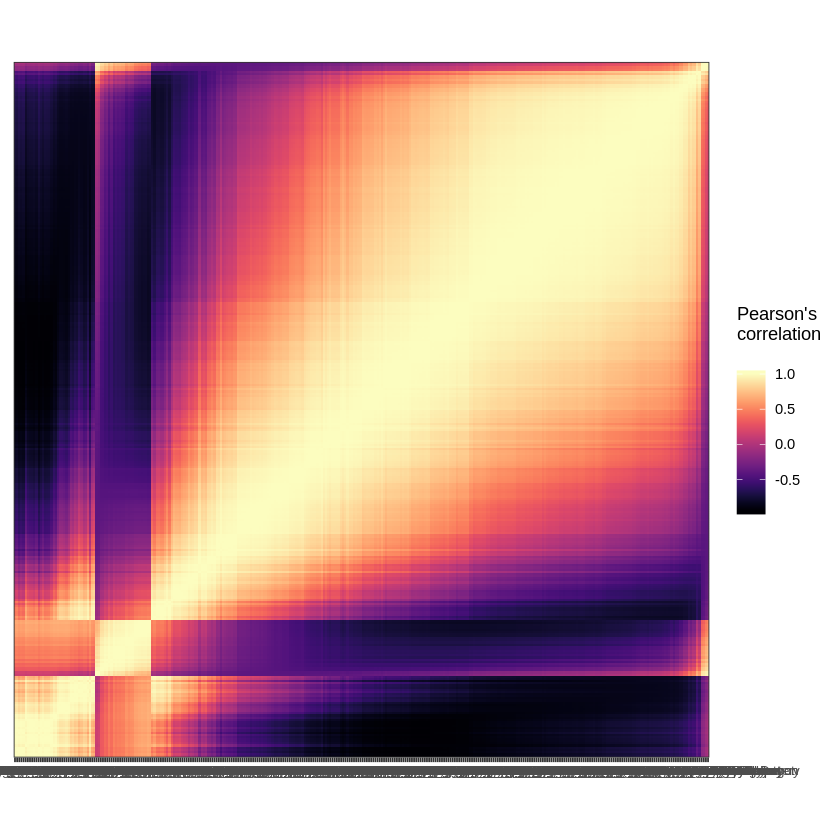

In [6]:
#identify clusters to make sense of the how site connections covary, and what the spatial patterns are
#correlation is a similarity metric, so just turn it into a dissimiliarity metric!
test <- corr_df2 %>%
    mutate(dissim=1-corr)%>%
    select(-corr) %>%
    spread(org_dest2,dissim) %>%
    select(-org_dest1)
dist <- as.dist(test)
fit <- hclust(dist, method="ward.D") #plot(fit)


#sort the data into groups
groups.3 = cutree(fit,3)
table(groups.3)
#what about 5 groups
groups.5 = cutree(fit,5)
table(groups.5)

#get group id for each connection
z <- rownames(as.matrix(groups.3))

clusters <- as.data.frame(groups.3) %>%
    mutate(org_dest = z) %>%
    rename(group="groups.3") %>%
    arrange(org_dest)

#join into the correlation data frame, order axes by group ID
corr_df3 <- inner_join(corr_df4_dist, clusters, by=c(org_dest1="org_dest")) %>%
    rename(conn1_group="group")
corr_df4 <- left_join(corr_df3, clusters, by=c(org_dest2="org_dest"))%>%
    rename(conn2_group="group") %>%
    arrange(conn1_group, conn2_group) 

#make the names into factors with the order based on group id
one <- as.vector(as.matrix(corr_df4 %>% distinct(org_dest1)))
two <- as.vector(as.matrix(corr_df4 %>% distinct(org_dest2)))

corr_df4$org_dest1 <- factor(corr_df4$org_dest1, levels=one)
corr_df4$org_dest2 <- factor(corr_df4$org_dest2, levels=two)

#name <- expression(r ^2)
#corr <- corr_df4_dist$dist_mid_to_mid_km
#plot
corr_plot <- ggplot(corr_df4, aes(org_dest1, org_dest2)) +
    geom_tile(aes(fill=corr)) + 
    coord_fixed() +
    scale_fill_viridis(option="magma", name="Pearson's\ncorrelation\n") + 
    theme_bw() + 
    theme(axis.title.x=element_blank(),
    axis.text.x=element_text(size=8),
    #axis.ticks.x=element_blank(),
    axis.title.y=element_blank(),
    axis.text.y=element_blank(), #element_text(size=1),
    axis.ticks.y=element_blank())#+
   # scale_x_continuous(breaks=c(0, 10, 20, 27))    #scale_colour_continuous(guide = "colorbar", guides(fill = guide_legend("title")))
    
corr_plot
#ggplot2::ggsave(filename="ConnectivityCorrelation.png",  plot=corr_plot, path="~/parentage/kernel_fitting/1340_loci/final_results/dispersal_route_correlation/")
#



In [7]:
corr_df3 <- inner_join(corr_df4_dist, clusters, by=c(org_dest1="org_dest")) %>%
    rename(conn1_group="group")
corr_df4 <- left_join(corr_df3, clusters, by=c(org_dest2="org_dest"))%>%
    rename(conn2_group="group") %>%
    arrange(conn1_group, conn2_group) 

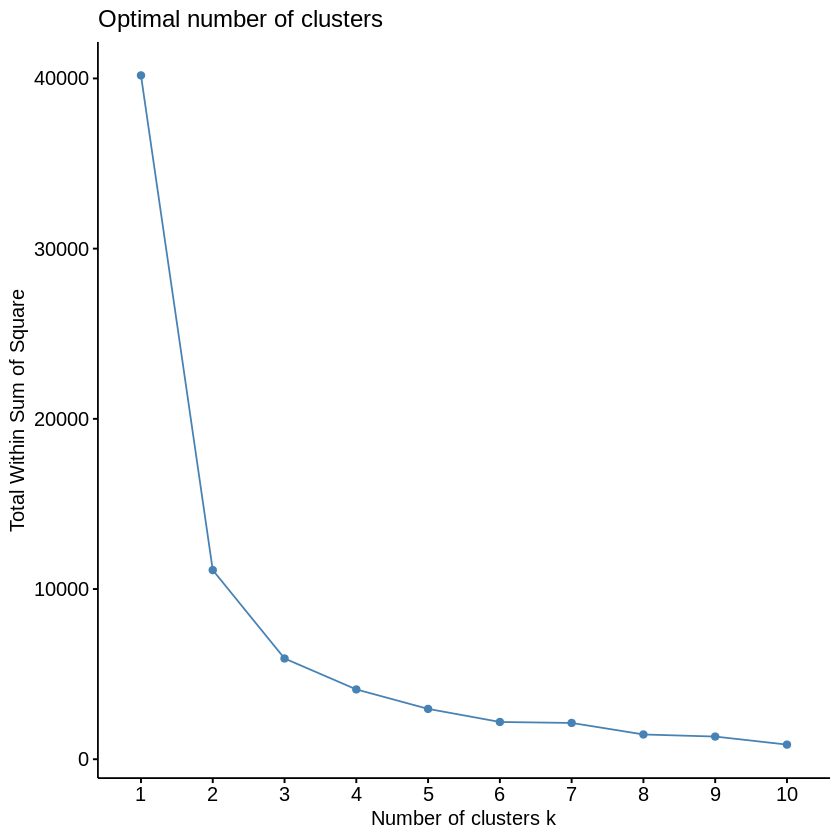

In [8]:
#pdf("~/parentage/kernel_fitting/1340_loci/final_results/dispersal_route_correlation/ClusterWSSElbow.pdf")
fviz_nbclust(corr_df, kmeans, method = "wss")
#dev.off()

In [9]:
#average corr in each group
(corr_df3 %>% 
 group_by(conn1_group) %>% 
 mutate(mean_corr=mean(corr)) %>%
 mutate(sd=sd(corr)) %>%
 mutate(se= sd(corr)/sqrt(nrow(corr_df3))) %>%
 group_by(mean_corr) %>%
 distinct(mean_corr, .keep_all = T))

org_dest1,org_dest2,corr,dist_mid_to_mid_km1,dist_mid_to_mid_km2,conn1_group,mean_corr,sd,se
Cabatoan_Cabatoan,Cabatoan_Cabatoan,1.0000000,0.000000,0,1,-0.2762090,0.6146265,0.001896995
Poroc Rose_Visca,Cabatoan_Cabatoan,0.4804864,1.265919,0,2,0.2267781,0.5313099,0.001639845
Hicgop South_San Agustin,Cabatoan_Cabatoan,-0.7986015,5.439796,0,3,0.3606153,0.6627142,0.002045414


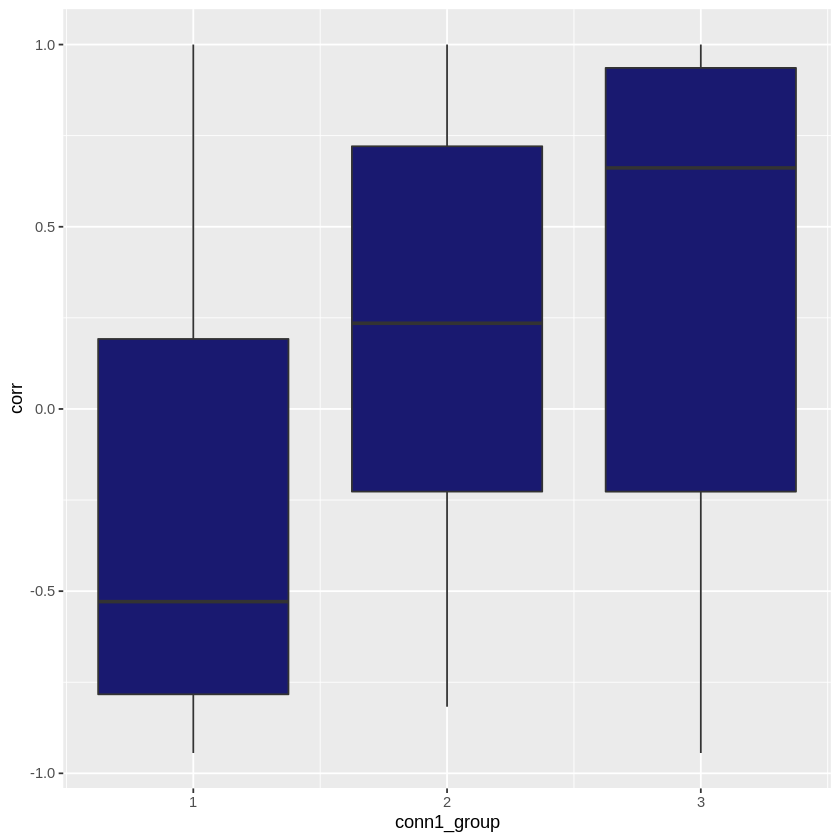

In [11]:
ggplot(corr_df3, aes(x = conn1_group, y = corr, group=conn1_group)) + 
  geom_boxplot(fill = "midnightblue")

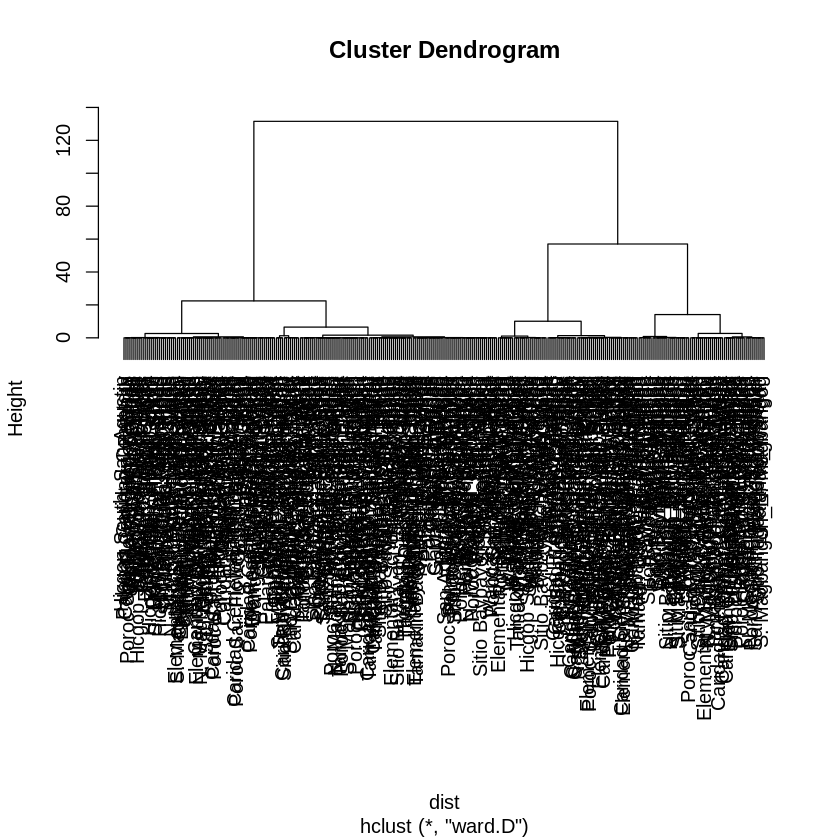

In [12]:
#plot cluster dendrogram
#pdf("~/parentage/kernel_fitting/1340_loci/final_results/ClusterDendrogram.pdf")
plot(fit)
#dev.off()

Saving 6.67 x 6.67 in image


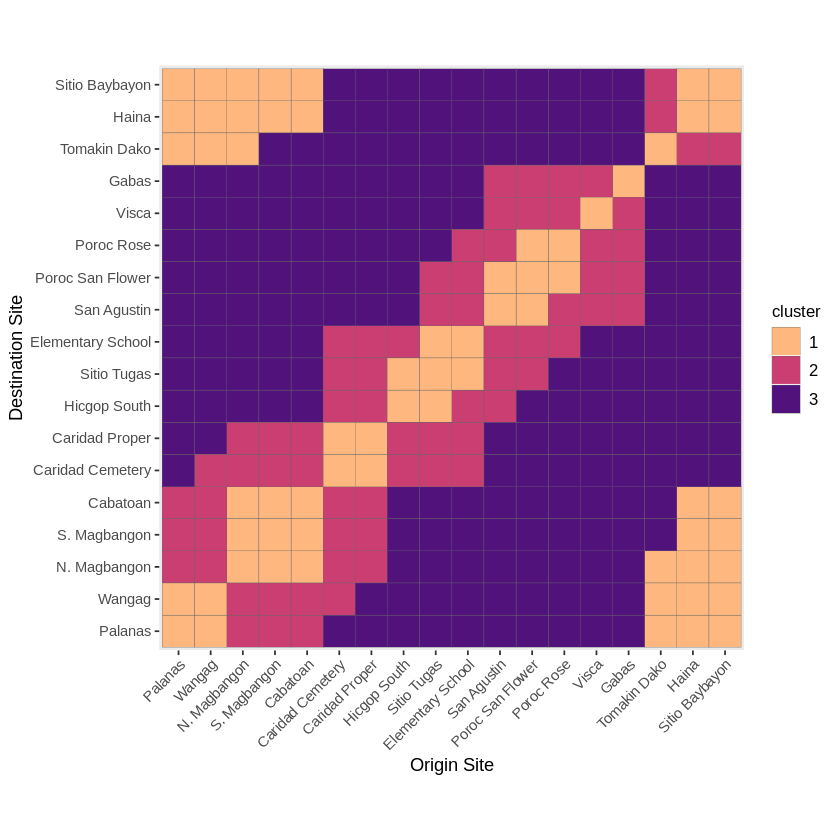

In [15]:
# is each group going a certain direction? Is there a relationship between physical distance and connectivity correlation?
clusters2 <- clusters %>% 
    separate(org_dest, c("org", "dest"), sep="_", extra="merge") %>% #make one column for connection id
    mutate(cluster=as.factor(group))
clusters2 <- clusters2 %>%
    mutate(org= ifelse(org=="Tamakin Dacot", "Tomakin Dako", org)) %>%
    mutate(dest= ifelse(dest=="Tamakin Dacot", "Tomakin Dako", dest))

#NORTH-SOUTH
clusters2$org <-factor(clusters2$org, levels=c("Palanas","Wangag","N. Magbangon","S. Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop South", "Sitio Tugas", "Elementary School", "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Visca", "Gabas", "Tomakin Dako" , "Haina","Sitio Baybayon"))
clusters2$dest <-factor(clusters2$dest, levels=c("Palanas","Wangag","N. Magbangon","S. Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop South", "Sitio Tugas", "Elementary School", "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Visca", "Gabas", "Tomakin Dako" , "Haina","Sitio Baybayon"))

#big-small
#clusters2$org <-factor(clusters2$org, levels=c("Wangag", "Sitio Baybayon", "Cabatoan", "N. Magbangon", "S. Magbangon", "Haina", "Palanas", "Tamakin Dacot", "Elementary School", "Hicgop South", "Visca", "Caridad Cemetery", "Caridad Proper", "Poroc Rose", "Sitio Tugas", "Sitio Lonas", "Gabas", "San Agustin", "Poroc San Flower"))
#clusters2$dest <-factor(clusters2$dest, levels=c("Wangag", "Sitio Baybayon", "Cabatoan", "N. Magbangon", "S. Magbangon", "Haina", "Palanas", "Tamakin Dacot", "Elementary School", "Hicgop South", "Visca", "Caridad Cemetery", "Caridad Proper", "Poroc Rose", "Sitio Tugas", "Sitio Lonas", "Gabas", "San Agustin", "Poroc San Flower"))



cluster_plot <- ggplot(clusters2, aes(org, dest)) +
geom_tile(aes(fill = cluster)) +
    geom_tile(aes(fill = cluster), color = "grey40") +
    #scale_fill_gradient(low = "white", high = "steelblue", name="Immigration Fraction") +
    scale_fill_manual(values= magma(3, alpha = 1, begin = 0.85, end = 0.25))+
    ylab("Destination Site") +
    xlab("Origin Site") +
    coord_fixed(ratio = 1) +
    theme(axis.text.x=element_text(angle=45,hjust=1)) +
    theme(plot.title = element_text(hjust = 1))+
    theme(legend.text=element_text(size=10))+
    theme(legend.title=element_text(size=10))+ 
    theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank())


cluster_plot
#ggsave(filename="NS_clusters.pdf", plot=cluster_plot, path="~/parentage/kernel_fitting/1340_loci/final_results/dispersal_route_correlation/", dpi="retina")


In [16]:
#what about standard deviation in each route?
sd_mat <- matrix(nrow=nrow(cdtall), ncol=nrow(cdtall))
names <- data.table(org_dest=as.character(), org_dest=as.character())

sd_df <- cdtall %>%
    gather(3:9, key=year, value=prob_dens) %>%
    group_by(org_site, dest_site) %>%
    summarise(sd=sd(prob_dens))

#cv is standardized by the mean
cv_df <- cdtall %>%
    gather(3:9, key=year, value=prob_dens) %>%
    group_by(org_site, dest_site) %>%
    summarise(cv=sd(prob_dens)/mean(prob_dens, na.rm=T))



ERROR: Error in nrow(cdtall): object 'cdtall' not found


In [70]:
sites_bigsmall <- as.matrix(site_width_info %>%
    mutate(site=as.character(site)) %>%
    arrange(desc(width_km)) %>%
    select(site) %>%
    mutate(site= ifelse(site=="Tamakin Dacot", "Tomakin Dako",site)))

In [71]:
str(site_width_info)

'data.frame':	18 obs. of  11 variables:
 $ site                  : Factor w/ 18 levels "Cabatoan","Caridad Cemetery",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ N_anem                : num  198 695 291 2303 2667 ...
 $ S_anem                : num  904 292 290 702 1340 3080 697 213 876 724 ...
 $ N_lat                 : num  10.9 10.8 10.8 10.8 10.7 ...
 $ N_lon                 : num  125 125 125 125 125 ...
 $ S_lat                 : num  10.9 10.8 10.8 10.8 10.7 ...
 $ S_lon                 : num  125 125 125 125 125 ...
 $ width_m               : num  202 276 107 177 120 ...
 $ width_km              : num  0.202 0.276 0.107 0.177 0.12 ...
 $ prob_disperse         : num  0.0202 0.0275 0.0107 0.0177 0.012 ...
 $ prob_disperse_abserror: num  2.25e-16 3.06e-16 1.19e-16 1.97e-16 1.33e-16 ...


In [ ]:
cdtall %>% filter(org_site=="Haina" & dest_site=="Haina")

In [72]:
mag_corr <- matrix(c("Haina", "N. Magbangon", "S. Magbangon"))
sites <- rbind(mag_corr, as.matrix(sites_bigsmall[3:length(sites_bigsmall)])) 


In [78]:
head(sites)

Haina
N. Magbangon
S. Magbangon
Wangag
Sitio Baybayon
Hicgop South


In [86]:
#write.csv(sd_df, file="~/parentage/kernel_fitting/1340_loci/final_results/dispersal_route_correlation/StanDevDF.csv", quote=FALSE, row.names=FALSE )
#write.csv(cv_df, file="~/parentage/kernel_fitting/1340_loci/final_results/dispersal_route_correlation/CoefVarDF.csv", quote=FALSE, row.names=FALSE )

sd_df <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/dispersal_route_correlation/StanDevDF.csv", stringsAsFactors = F)#%>%
    #mutate(org_site= ifelse(org_site=="Tamakin Dacot", "Tomakin Dako", org_site)) %>%
    #mutate(dest_site= ifelse(dest_site=="Tamakin Dacot", "Tomakin Dako", dest_site))
cv_df <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/dispersal_route_correlation/CoefVarDF.csv", stringsAsFactors = F)#%>%
    #mutate(org_site= ifelse(org_site=="Tamakin Dacot", "Tomakin Dako", org_site)) %>%
    #mutate(dest_site= ifelse(dest_site=="Tamakin Dacot", "Tomakin Dako", dest_site)) 

#cv_df$org_site <-factor(cv_df$org_site, levels=sites)
#cv_df$dest_site <-factor(cv_df$dest_site, levels=sites)


In [81]:
str(sd_df)

'data.frame':	324 obs. of  3 variables:
 $ org_site : chr  "Cabatoan" "Cabatoan" "Cabatoan" "Cabatoan" ...
 $ dest_site: chr  "Cabatoan" "Caridad Cemetery" "Caridad Proper" "Elementary School" ...
 $ sd       : num  0.013773 0.003916 0.00125 0.001347 0.000573 ...


In [82]:
summary(cv_df$cv)
sd(cv_df$cv)/sqrt(length(cv_df$cv))
sd(cv_df$cv)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4512  0.4773  0.5292  0.5934  0.6884  1.0078 

[1] 0.008159534

[1] 0.1468716

In [83]:
(cv_df %>% filter(cv == max(cv)))

org_site,dest_site,cv
Poroc San Flower,Poroc San Flower,1.007761


Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Saving 6.67 x 6.67 in image


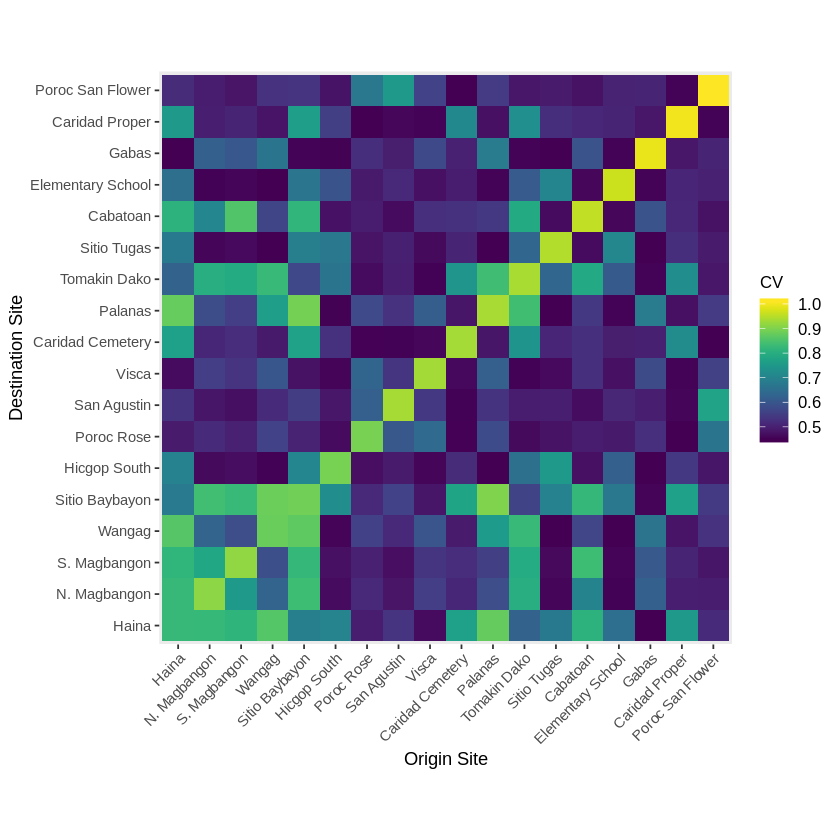

In [87]:
#NORTH-SOUTH
#cv_df$org_site <-factor(cv_df$org_site, levels=c("Palanas","Wangag","N. Magbangon","S. Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop South", "Sitio Tugas", "Elementary School", "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Visca", "Gabas", "Tamakin Dacot" , "Haina","Sitio Baybayon"))
#cv_df$dest_site <-factor(cv_df$dest_site, levels=c("Palanas","Wangag","N. Magbangon","S. Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop South", "Sitio Tugas", "Elementary School", "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Visca", "Gabas", "Tamakin Dacot" , "Haina","Sitio Baybayon"))
    #mutate(cluster=as.factor(group))
cv_df <- cv_df %>%
    mutate(org_site= ifelse(org_site=="Tamakin Dacot", "Tomakin Dako", org_site)) %>%
    mutate(dest_site= ifelse(dest_site=="Tamakin Dacot", "Tomakin Dako", dest_site))
#
#big-small
cv_df$org_site <-factor(cv_df$org_site, levels=sites)
cv_df$dest_site <-factor(cv_df$dest_site, levels=sites)


#name <- expression(r ^2)
#sd <- sd_df4_dist$dist_mid_to_mid_km
#plot
cv_plot <- ggplot(cv_df, aes(org_site, dest_site)) +
    geom_tile(aes(fill=cv)) + 
    coord_fixed() +
    scale_fill_viridis(option="viridis", name="CV")+#name="Standard\ndeviation\n") + 
    ylab("Destination Site") +
    xlab("Origin Site") +
    coord_fixed(ratio = 1) +
    theme(axis.text.x=element_text(angle=45,hjust=1)) +
    theme(plot.title = element_text(hjust = 1))+
    theme(legend.text=element_text(size=10))+
    theme(legend.title=element_text(size=10))+ 
    theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank())

   # scale_x_continuous(breaks=c(0, 10, 20, 27))    #scale_colour_continuous(guide = "colorbar", guides(fill = guide_legend("title")))
    
cv_plot
ggplot2::ggsave(filename="ConnectivityCoefVarBigSmall.pdf",  plot=cv_plot, path="~/parentage/kernel_fitting/1340_loci/final_results/dispersal_route_correlation/", dpi = "retina")
